In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_SYN_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
clf_type_space = [e.value for e in ClfType]

In [3]:
em_syn_df = pd.read_csv(CONNECTOME_SYN_TABLE_PATH)
print(len(em_syn_df))
em_syn_df.head()

13506902


,Unnamed: 0,id_,dist_to_post_syn_soma,size,center_position,depth,pre_clf_type,pre_cell_type,pre_m_type,post_clf_type,post_cell_type,post_mtype_type
0,0,42727255,11.914092,1.096,[ 436552 1060520 887560],-1.0,E,5P-ET,L6tall-a,E,6P-IT,L6tall-c
1,1,176815515,17.153281,1.524,[744344 848240 630880],-1.0,I,BC,DTC,E,6P-IT,L6short-a
2,2,176816501,9.309928,0.444,[749436 853228 631360],-1.0,I,BC,DTC,E,6P-IT,L6short-a
3,3,140956220,116.817573,3.136,[667184 889672 641640],-1.0,E,5P-IT,L5a,E,6P-IT,L6short-a
4,4,182281805,60.572679,3.704,[754952 822448 623760],-1.0,I,BC,PTC,E,6P-IT,L6short-a


### Synapse Dist to Soma

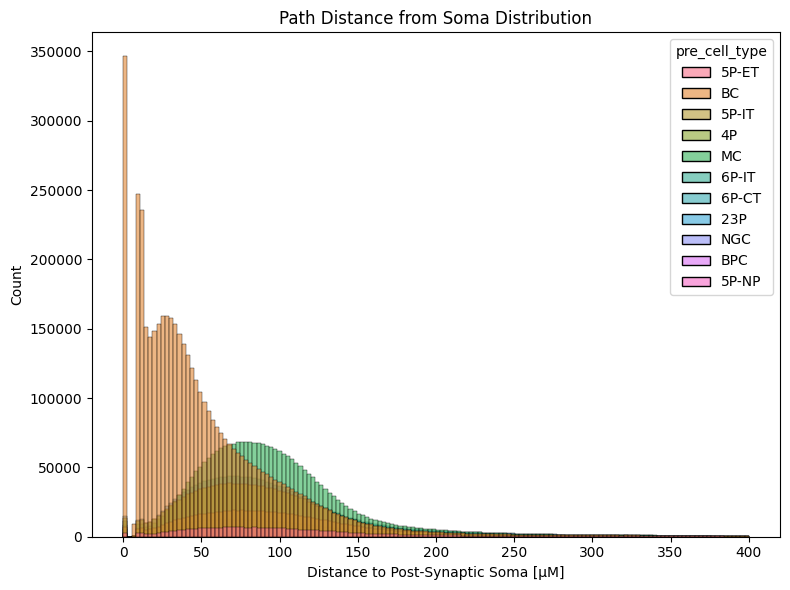

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=em_syn_df, x="dist_to_post_syn_soma", hue="pre_cell_type",bins=150,
             multiple="layer", alpha=0.6, binrange=(0, 400), ax=ax)
ax.set_title("Path Distance from Soma Distribution (based on post synaptic neuron type)");
ax.set_xlabel("Distance to Post-Synaptic Soma [µM]");ax.set_ylabel("Count")
plt.tight_layout();plt.show()
# TODO: 11 plots - per POST - syn type. 

In [47]:
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.histplot(data=em_syn_df, x="dist_to_post_syn_soma", hue="post_cell_type",bins=150,
#              multiple="layer", alpha=0.6, binrange=(0, 400), ax=ax)
# ax.set_title("Path Distance from Soma Distribution (based on post synaptic neuron type)");
# ax.set_xlabel("Distance to Post-Synaptic Soma [µM]");ax.set_ylabel("Count")
# plt.tight_layout();plt.show()

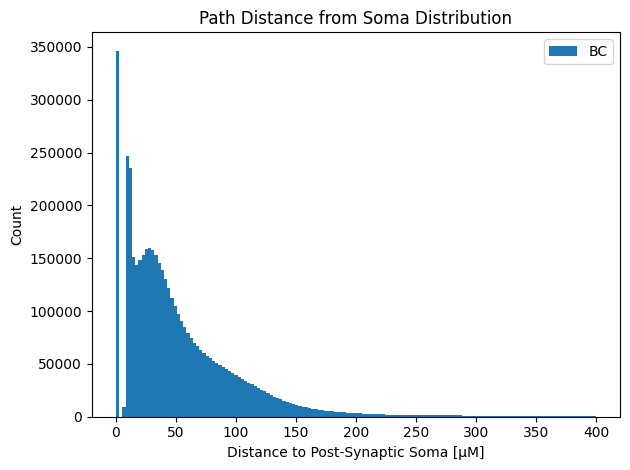

<Figure size 640x480 with 0 Axes>

In [44]:
ax = em_syn_df[em_syn_df.pre_cell_type == 'BC']['dist_to_post_syn_soma'].plot.hist(
    bins=150,
    range=(0, 400),
    label='BC',
)

ax.set_title("Path Distance from Soma Distribution");ax.set_xlabel("Distance to Post-Synaptic Soma [µM]");ax.set_ylabel("Count")
ax.legend();plt.tight_layout();plt.show()
# sns.despine()

In [26]:
# # plt.style.use('seaborn')
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.violinplot(
#     data=em_syn_df,
#     x='pre_cell_type',
#     y='dist_to_post_syn_soma',
#     ax=ax,
#     hue="pre_clf_type",
#     cut=0,  # Don't extend the violin plot past the range of the data
#     scale='width'  # Scale each violin to have the same maximum width
# )

# ax.set_title("Path Distance from Soma Distribution")
# ax.set_xlabel("Cell Type");ax.set_ylabel("Distance to Post-Synaptic Soma [µM]")
# ax.set_ylim(0, 400);sns.despine();plt.tight_layout();plt.show()

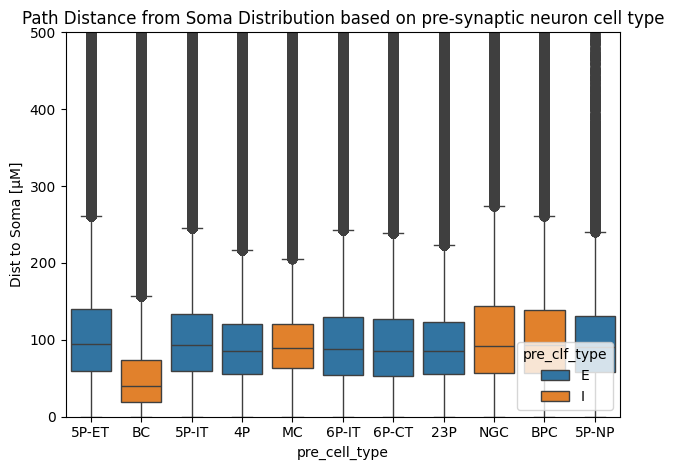

In [16]:
sns.boxplot(x="pre_cell_type", y="dist_to_post_syn_soma", hue="pre_clf_type", data=em_syn_df)
plt.title("Path Distance from Soma Distribution")
plt.ylim(0, 500);plt.ylabel("Dist to Soma [µM]")
plt.tight_layout();plt.show()

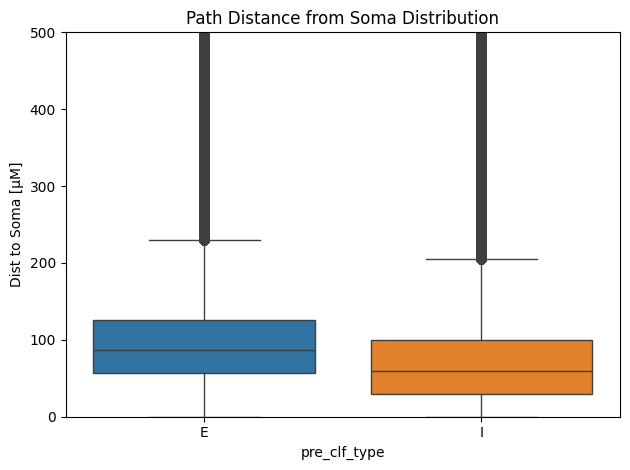

In [17]:
sns.boxplot(x="pre_clf_type", y="dist_to_post_syn_soma", hue="pre_clf_type", data=em_syn_df)
plt.title("Path Distance from Soma Distribution")
plt.ylim(0, 500);plt.ylabel("Dist to Soma [µM]")
plt.tight_layout();plt.show()

### Synapse Size

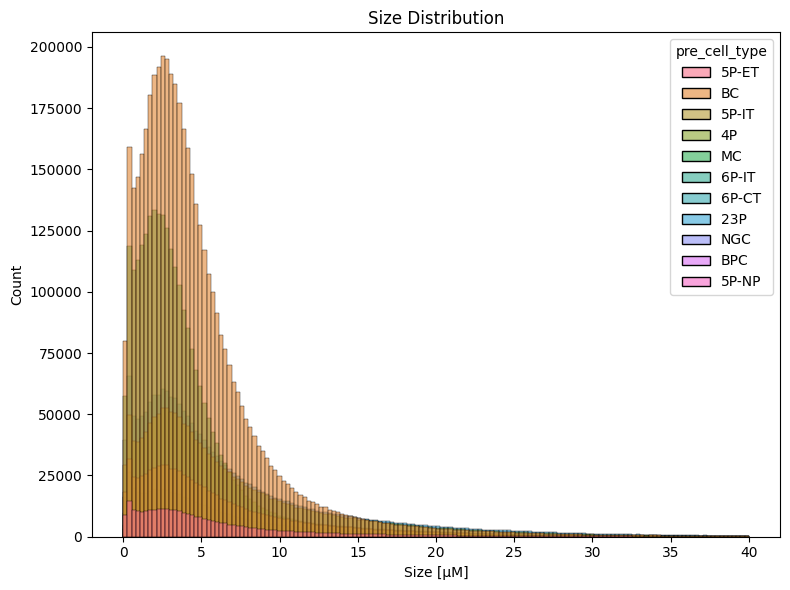

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=em_syn_df, x="size", hue="pre_cell_type",bins=150,
             multiple="layer", alpha=0.6, binrange=(0, 40), ax=ax)

ax.set_title("Size Distribution");ax.set_xlabel("Size [µM]");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

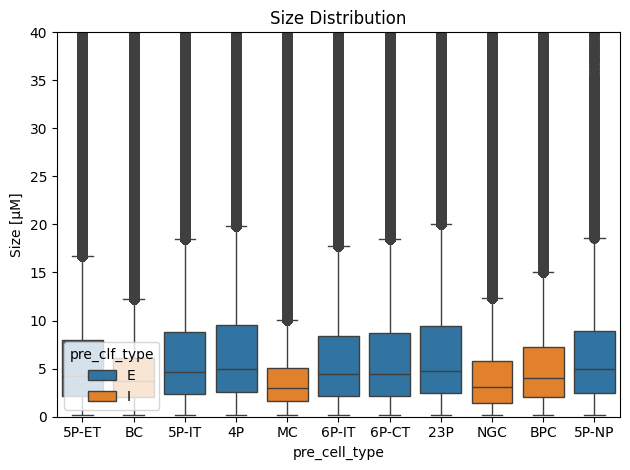

In [22]:
sns.boxplot(x="pre_cell_type", y="size", hue="pre_clf_type", data=em_syn_df)
plt.title("Size Distribution"); plt.ylabel("Size [µM]"),plt.ylim(0, 40)
plt.tight_layout();plt.show()

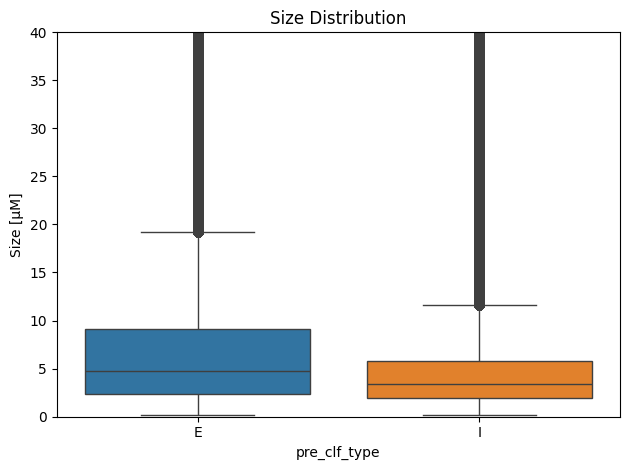

In [23]:
sns.boxplot(x="pre_clf_type", y="size", hue="pre_clf_type", data=em_syn_df)
plt.title("Size Distribution"); plt.ylabel("Size [µM]"),plt.ylim(0, 40)
plt.tight_layout();plt.show()

### Size vs. Dist to Soma

C:\Users\dean.geckt\Documents\Dendro-Synaptome\.venv_39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


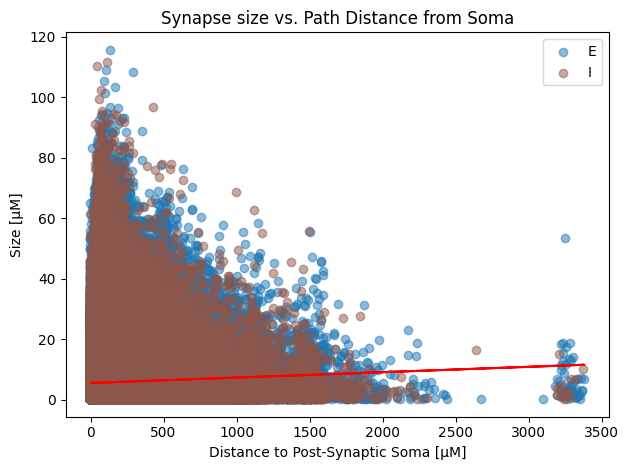

In [25]:
df = em_syn_df[['dist_to_post_syn_soma', 'size', 'pre_clf_type']]
X = df['dist_to_post_syn_soma']
y = df['size']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

unique_types = df['pre_clf_type'].unique()
color_map = plt.colormaps['tab10']
color_dict = {t: color_map(i/len(unique_types)) for i, t in enumerate(unique_types)}
for t in unique_types:
    mask = df['pre_clf_type'] == t
    plt.scatter(df.loc[mask, 'dist_to_post_syn_soma'], 
                df.loc[mask, 'size'], 
                alpha=0.5, 
                c=[color_dict[t]], 
                label=t)

plt.plot(df['dist_to_post_syn_soma'], model.predict(X), color='red')
plt.title("Synapse size vs. Path Distance from Soma"); plt.ylabel("Size [µM]"); plt.xlabel("Distance to Post-Synaptic Soma [µM]");
plt.tight_layout();plt.legend(); plt.show()